In [ ]:
### Оставил только итоговый код без промежуточных результатов и итоговый расчёт ROC AUC

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymorphy2 # Морфологический анализатор.
from bs4 import BeautifulSoup # Превращалка html в текст.
import re # Регулярные выражения.
from collections import Counter # Не считать же частоты самим.
import math # Корень квадратный.
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
import pickle
import operator
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

In [3]:
class Vacancys:
        
    # Конструктор - вызывается при создании объекта и инициализирует его.
    def __init__(self):
        self.desc=[]     # Описание вакансии.
        self.names=[]       # Название вакансии.
        self.dictionaries=[] # Словари для каждой вакансии.
        self.IDs =[] # Айдишники вакансий
        # Создаем и загружаем морфологический словарь.
        self.morph=pymorphy2.MorphAnalyzer()

    # Загрузка вакансий из датафрейма.
    def getVac (self, df):
        for i in range (0,df.shape[0]):
            self.names.append(df.loc[i,'name'])
            self.IDs.append(df.loc[i,'id'])
            self.desc.append(BeautifulSoup(df.loc[i,'description'], "html5lib").get_text())
            

    # Потроение вектора для вакансии.
    posConv={'ADJF':'_ADJ','NOUN':'_NOUN','VERB':'_VERB'}
    def getDictionary(self, text, needPos=None):
        words=[a[0] for a in re.findall("([А-ЯЁа-яё]+(-[А-ЯЁа-яё]+)*)", text)]
        reswords=[]
    
        for w in words:
            wordform=self.morph.parse(w)[0]
            try:
                if wordform.tag.POS in ['ADJF', 'NOUN', 'VERB']: # если результат находится в значимых частях речи
                    if needPos!=None:
                        reswords.append(wordform.normal_form+self.posConv[wordform.tag.POS]) #склей начальную форму с
                    else:
                        reswords.append(wordform.normal_form)# или просто возьми начальнуб форму
            except:
                pass
            
        stat=Counter(reswords)
        # фильтр по частоте
        # stat={a: stat[a] for a in stat.keys() if stat[a]>1}
        return stat
    # Посчитаем вектора для всех вакансий.
    def calcDictionaries(self, needPos=None):
        self.dictionaries=[]
        for a in self.desc:
            self.dictionaries.append(self.getDictionary(a, needPos))
    # Поиск вакансии по названию.
    def findVacById (self, id):
        if id in self.IDs:
            return self.IDs.index(id)
        else:
            return -1
# Косинусная мера
def cosineSimilarity(a, b):
    if len(a.keys())==0 or len(b.keys())==0:
        return 0
    sumab=sum([a[na]*b[na] for na in a.keys() if na in b.keys()])
    suma2=sum([a[na]*a[na] for na in a.keys()])
    sumb2=sum([b[nb]*b[nb] for nb in b.keys()])
    return sumab/math.sqrt(suma2*sumb2)

#Функция подготовки массива
def vac_prepare (dfr):
    # Убираем теги.
    for i in range (0,dfr.shape[0]):
        dfr.loc[i,'description'] = BeautifulSoup(dfr.loc[i,'description'], "html5lib").get_text()
    # В текст вакансии добавляем её название, чтобы попало в словарь
    dfr.loc[:,'name']  = dfr.loc[:,'name'].add('. ')
    dfr.loc[:,'description']  = dfr.loc[:,'name'].add(dfr.loc[:,'description'])
    return dfr

In [ ]:
#==============ИТОГОВЫЙ КОД===================
    # 1. Считаем словарь для каждой вакансии
df = pd.read_csv('train.csv', sep='\t', encoding='utf8')
df = vac_prepare (df) # Подготовка массива: к тексту вакансии добавляем её название (чтобы учесть в словаре) и убираем теги
Vac = Vacancys()
Vac.getVac(df) # Загружаем вакансии 
Vac.calcDictionaries() # Считаем словари

    # 2. Для обучения будем использовать косинусную меру каждой вакансии к тренировочному словарю
    #  Тренировочным словарём будем считать ТОП-100 по частотам из словаря равного разности частот общего словаря интересных выкансий и общего словаря неинтересных вакансий 
    
    #Считаем общий словарь интересных вакансий
TargetVac = df.loc[df['target'] == 1, 'id']
TargetVacText=' '.join([Vac.desc[Vac.findVacById(id)] for id in TargetVac]) #Складываем тексты
TargetVacDict=Vac.getDictionary(TargetVacText)
    #Считаем словарь неинтересных вакансий
NonTargetVac = df.loc[df['target'] == 0, 'id']
NonTargetVacText=' '.join([Vac.desc[Vac.findVacById(id)] for id in NonTargetVac]) 
NonTargetVacDict=Vac.getDictionary(NonTargetVacText)
#Сохраняем всё в файлы
file = open('TargetVacDict.dmp','wb')
pickle.dump(TargetVacDict,file)
file.close()
file = open('NonTargetVacDict.dmp','wb')
pickle.dump(NonTargetVacDict,file)
file.close()
file = open('Vac.dmp','wb')
pickle.dump(Vac,file)
file.close()

    #Тренировочный словарь: вычитаем из интересного словаря неинтересный
TrainVacDict = TargetVacDict 
for i in TargetVacDict.keys():
    if i in NonTargetVacDict.keys():
        TrainVacDict[i] = TargetVacDict[i] - NonTargetVacDict[i]*0.88 # Коэффициент по отношению количества интересных/неинтерсных вакансий
    # Сортировка словаря по частоте
sortVacDict = sorted(TrainVacDict.items(), key =operator.itemgetter(1), reverse = True)
    # Удаляем в тренировочном словаре слова не из ТОП-100
for i in range (100,len(sortVacDict)):
    del TrainVacDict[sortVacDict[i][0]]
    # Считаем косинусную меру всех вакансий с тренировочным словарём и добавляем как признак в исходный массив   
for i in df['id']:
    df.loc[df['id']==i,'cos_100'] = cosineSimilarity(TrainVacDict, Vac.dictionaries[Vac.findVacById(i)])
#Сохраняем df с признаками
df.to_csv('df_train_100_new.csv', sep = '\t', encoding = 'utf-8')

0.8149013796557192


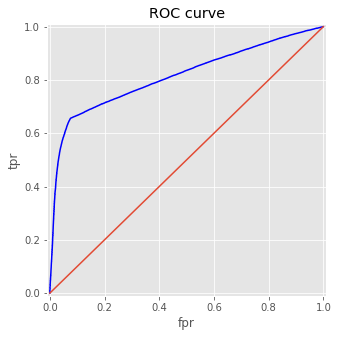

In [47]:
# Загружаем фрейм с признаком косинусной меры
df = pd.read_csv('df_train_100_new.csv', sep='\t', encoding='utf8')    

    # 3. Обучим линейную регерссию
X = df.drop(['target', 'name', 'description'], axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
LR = LogisticRegression()
LR.fit(X_train, y_train)
predict_LR = LR.predict(X_test)

    # 4. Считаем ROC AUC
plt.figure(figsize=(5, 5))
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid(True)
plt.title('ROC curve')
plt.xlim((-0.01, 1.01))
plt.ylim((-0.01, 1.01))
predict_proba = LR.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predict_proba[:,1])
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1])
print (roc_auc_score(y_test, predict_proba[:,1]))

In [52]:
cross_val_score(LR, X_test, y_test, scoring='roc_auc', cv=10).mean()

0.8154244515810873